# Job a thon NOV 2021


## Import Library

In [73]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.preprocessing import sequence
from keras.layers import Input, Dense, Dropout, BatchNormalization, SeparableConv1D, Reshape, LSTM
from keras.layers import DepthwiseConv2D,AveragePooling2D, Concatenate
from keras.models import Model
from keras.backend import squeeze
from keras.regularizers import l2

## Import Data

In [6]:
train_data = pd.read_csv('../../Data/train.csv', parse_dates=['MMM-YY', 'Dateofjoining', 'LastWorkingDate'])
test_data = pd.read_csv('../../Data/test.csv')

In [12]:
print (f'Training Data Shape  - {train_data.shape}')
print (f'Testing  Data Shape  - {test_data.shape}')

print(f'\n We have {train_data.shape[0]} rows and {train_data.shape[1]} columns in Train Set Whereas \
{test_data.shape[0]} rows and {test_data.shape[1]} columns in Test Set')

Training Data Shape  - (19104, 13)
Testing  Data Shape  - (741, 1)

 We have 19104 rows and 13 columns in Train Set Whereas 741 rows and 1 columns in Test Set


In [16]:
#Dtype == Object
object_col = list(train_data.select_dtypes(include='object').columns)
print(f'Number of "Object Features" in Train Set are {len(object_col)} :-   {", ".join(object_col)}')

#Dtype == int or float
num_col = list(train_data.select_dtypes(include=['int64', 'float']).columns)
print(f'\n\nNumber of "Numerical Features" in Train Set are {len(num_col)} :-  {", ".join(num_col)}')

Number of "Object Features" in Train Set are 3 :-   Gender, City, Education_Level


Number of "Numerical Features" in Train Set are 7 :-  Emp_ID, Age, Salary, Joining Designation, Designation, Total Business Value, Quarterly Rating


In [23]:
#Null value in Train
null_cols1 = train_data.columns[train_data.isnull().sum()!=0]
df1 = train_data.isnull().sum()[null_cols1].to_frame(name = 'Train_Null_Count')
df1['Train_Percent %'] = round(df1.Train_Null_Count / train_data.shape[0] * 100, 2)

df1

,Train_Null_Count,Train_Percent %
LastWorkingDate,17488,91.54


Thats huge percentage, probably null value is for row where emp where still working.

In [24]:
Features = []
for i in train_data.columns:
    Features.append([i, train_data[i].nunique(), train_data[i].drop_duplicates().values])
pd.DataFrame(Features, columns = ['Features', 'Unique Number', 'Values'])

,Features,Unique Number,Values
0,MMM-YY,24,"[2016-01-01T00:00:00.000000000, 2016-02-01T00:..."
1,Emp_ID,2381,"[1, 2, 4, 5, 6, 8, 11, 12, 13, 14, 16, 17, 18,..."
2,Age,36,"[28, 31, 43, 29, 34, 35, 30, 39, 42, 27, 26, 3..."
3,Gender,2,"[Male, Female]"
4,City,29,"[C23, C7, C13, C9, C11, C2, C19, C26, C20, C17..."
5,Education_Level,3,"[Master, College, Bachelor]"
6,Salary,2383,"[57387, 67016, 65603, 46368, 78728, 70656, 421..."
7,Dateofjoining,869,"[2015-12-24T00:00:00.000000000, 2017-11-06T00:..."
8,LastWorkingDate,493,"[NaT, 2016-03-11T00:00:00.000000000, 2017-04-2..."
9,Joining Designation,5,"[1, 2, 3, 4, 5]"


## Data Visualization

In [25]:
d = train_data.copy()

In [29]:
#check no. of Employees
print('total employees - ',d.Emp_ID.nunique())

emp_left = d.loc[:, ['Emp_ID', 'LastWorkingDate']] \
                .dropna().reset_index(drop=True)
print('employees left the company - ', emp_left.shape[0])
print('remaining employees - ', d.Emp_ID.nunique() - emp_left.shape[0])

total employees -  2381
employees left the company -  1616
remaining employees -  765


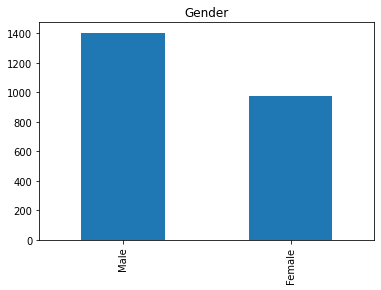

In [83]:
d.groupby('Emp_ID').last()['Gender'].value_counts().plot(kind='bar', title='Gender');

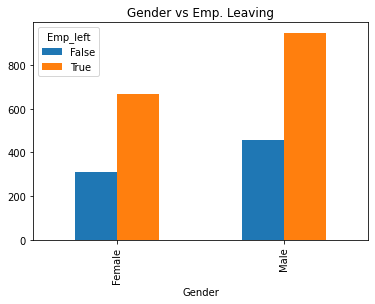

In [96]:
d['Emp_left'] = d.apply(lambda x:True if x['Emp_ID'] in emp_left.Emp_ID.tolist() else False, axis=1)
d.groupby(['Emp_ID']).last().groupby(['Gender', 'Emp_left']).size().unstack().plot(kind='bar', title='Gender vs Emp. Leaving');

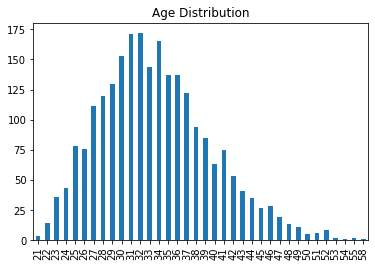

In [91]:
d.groupby(['Emp_ID']).last().Age.value_counts().sort_index().plot(kind = 'bar', title='Age Distribution');

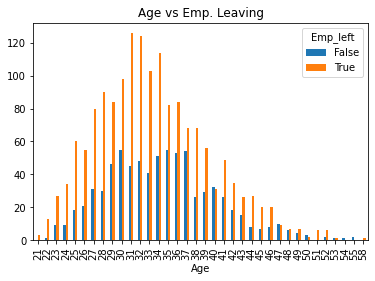

In [95]:
d.groupby(['Emp_ID']).last().groupby(['Age', 'Emp_left']).size().unstack().plot(kind='bar', title='Age vs Emp. Leaving');

## Feature generation

In [48]:
d = train_data.copy()

In [49]:
#name self explainatory
# Average salary by age
age_avg_salary = d.groupby('Emp_ID').last().groupby(['Age'])['Salary'].mean()
# Average salary by education
education_avg_salary = d.groupby('Emp_ID').last().groupby(['Education_Level'])['Salary'].mean()
city_avg_salary = d.groupby('Emp_ID').last().groupby(['City'])['Salary'].mean()
gender_avg_salary = d.groupby('Emp_ID').last().groupby(['Gender'])['Salary'].mean()

In [50]:
# converting Gender
d['Gender_c'] = d.Gender.map({'Male':1, 'Female':0})

In [52]:
# Calculate Working days of emp. at the time of monthly report
    
working = list()
for row in d.itertuples():
  if pd.isnull(row.LastWorkingDate):
    if row.Dateofjoining == 0:
      working.append(0)
    else:
      day = (row._1-row.Dateofjoining).days
      if day <1:
        working.append(1)
      else:
        working.append(day)
  else:
    working.append((row.LastWorkingDate - row.Dateofjoining).days)

d['Working_days'] = working

In [53]:
#is TBV negative on given monthly report
d['IS_TBV_Neg'] = d['Total Business Value'] < 0
#is TBV zero on given monthly report
d['IS_TBV_Zero'] = d['Total Business Value'] == 0
#Increase of TBV from previous month report
d['Inc_TBV'] = d['Total Business Value'] - d.groupby('Emp_ID')['Total Business Value'].shift()

In [54]:
#Monthly lag, choose 24 cus there is 2 year report
for i in range(1, 24):
    d[f'TBV_lag_{i}'] = d.groupby('Emp_ID')['Total Business Value'].shift(i)

# Monthly rolling sum
for i in  range(2, 24):
    d[f'TBV_rolling_{i}'] = d.groupby('Emp_ID')['Total Business Value'].rolling(i).sum().tolist()

In [55]:

# Salary increase by how much
d['Salary_inc'] = (d.Salary - d.groupby('Emp_ID').Salary.shift(1)).fillna(0)

# Salary increase recently or not
df = list()
dd = d['Salary_inc'].tolist()
for i in range(len(dd)):
    if dd[i] !=0:
        df.append(1)
    else:
        try:  
            if df[i-1] == 1:
                df.append(1)
            else:
                df.append(0)
        except:
            df.append(0)
            
d['IS_SALARY_INC'] = df

In [56]:
#salary divide by age
d = d.assign(salary_per_age = lambda x:x.Salary/x.Age)
#TBV divide by age
d = d.assign(tbv_per_age = lambda x: x['Total Business Value']/x.Age)

d['age_avg_salary'] = age_avg_salary[d.Age.unique().tolist()[-1]]
d['education_avg_salary'] = education_avg_salary[d.Education_Level.unique().tolist()[0]]
d['city_avg_salary'] = city_avg_salary[d.City.unique().tolist()[0]]

# salary divide by working days
d = d.assign(Salary_per_working_day = lambda x:np.where(x.Working_days != 0 , x.Salary/x.Working_days, 0))
# TBV divide by working days
d = d.assign(TBV_per_working_day = lambda x:np.where(x.Working_days != 0 ,x['Total Business Value']/x.Working_days, 0))
# Month of report
d = d.assign(month = lambda x: x['MMM-YY'].dt.month)

In [57]:
# get dummy the two col.
col_getd = ['City',	'Education_Level']
d = pd.get_dummies(d.loc[:, col_getd]) \
      .merge(d, left_index=True , right_index=True)

In [58]:
"', '".join(d.columns.tolist())

"City_C1', 'City_C10', 'City_C11', 'City_C12', 'City_C13', 'City_C14', 'City_C15', 'City_C16', 'City_C17', 'City_C18', 'City_C19', 'City_C2', 'City_C20', 'City_C21', 'City_C22', 'City_C23', 'City_C24', 'City_C25', 'City_C26', 'City_C27', 'City_C28', 'City_C29', 'City_C3', 'City_C4', 'City_C5', 'City_C6', 'City_C7', 'City_C8', 'City_C9', 'Education_Level_Bachelor', 'Education_Level_College', 'Education_Level_Master', 'MMM-YY', 'Emp_ID', 'Age', 'Gender', 'City', 'Education_Level', 'Salary', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation', 'Designation', 'Total Business Value', 'Quarterly Rating', 'Gender_c', 'Working_days', 'IS_TBV_Neg', 'IS_TBV_Zero', 'Inc_TBV', 'TBV_lag_1', 'TBV_lag_2', 'TBV_lag_3', 'TBV_lag_4', 'TBV_lag_5', 'TBV_lag_6', 'TBV_lag_7', 'TBV_lag_8', 'TBV_lag_9', 'TBV_lag_10', 'TBV_lag_11', 'TBV_lag_12', 'TBV_lag_13', 'TBV_lag_14', 'TBV_lag_15', 'TBV_lag_16', 'TBV_lag_17', 'TBV_lag_18', 'TBV_lag_19', 'TBV_lag_20', 'TBV_lag_21', 'TBV_lag_22', 'TBV_lag_23', 'TBV_ro

In [59]:
ind_col = ['City_C1', 'City_C10', 'City_C11', 'City_C12', 'City_C13', 'City_C14', 'City_C15', 'City_C16', 'City_C17', 'City_C18', 'City_C19', 'City_C2',
           'City_C20', 'City_C21', 'City_C22', 'City_C23', 'City_C24', 'City_C25', 'City_C26', 'City_C27', 'City_C28', 'City_C29', 'City_C3', 'City_C4',
           'City_C5', 'City_C6', 'City_C7', 'City_C8', 'City_C9', 'Education_Level_Bachelor', 'Education_Level_College', 'Education_Level_Master',
           'Age', 'Salary', 'Joining Designation', 'Designation', 'Total Business Value', 'Quarterly Rating', 'Gender_c', 'Working_days', 'IS_TBV_Neg',
           'IS_TBV_Zero', 'Inc_TBV', 'TBV_lag_1', 'TBV_lag_2', 'TBV_lag_3', 'TBV_lag_4', 'TBV_lag_5', 'TBV_lag_6', 'TBV_lag_7', 'TBV_lag_8', 'TBV_lag_9',
           'TBV_lag_10', 'TBV_lag_11', 'TBV_lag_12', 'TBV_lag_13', 'TBV_lag_14', 'TBV_lag_15', 'TBV_lag_16', 'TBV_lag_17', 'TBV_lag_18', 'TBV_lag_19',
           'TBV_lag_20', 'TBV_lag_21', 'TBV_lag_22', 'TBV_lag_23', 'TBV_rolling_2', 'TBV_rolling_3', 'TBV_rolling_4', 'TBV_rolling_5', 'TBV_rolling_6',
           'TBV_rolling_7', 'TBV_rolling_8', 'TBV_rolling_9', 'TBV_rolling_10', 'TBV_rolling_11', 'TBV_rolling_12', 'TBV_rolling_13', 'TBV_rolling_14',
           'TBV_rolling_15', 'TBV_rolling_16', 'TBV_rolling_17', 'TBV_rolling_18', 'TBV_rolling_19', 'TBV_rolling_20', 'TBV_rolling_21', 'TBV_rolling_22',
           'TBV_rolling_23', 'Salary_inc', 'IS_SALARY_INC', 'salary_per_age', 'tbv_per_age', 'age_avg_salary', 'education_avg_salary', 'city_avg_salary',
           'Salary_per_working_day', 'TBV_per_working_day', 'month']
len(ind_col)

98

In [60]:
# fit the standard Scaler 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(d.loc[:, ind_col[:]].fillna(0))


StandardScaler()

In [75]:
# all the above feature generation on the given dataset
# this is for jan, feb, march, april, may, june data
def feature_add(t):
    t['IS_TBV_Neg'] = t['Total Business Value'] < 0
    t['IS_TBV_Zero'] = t['Total Business Value'] == 0
    t['Inc_TBV'] = t['Total Business Value'] - t['Total Business Value'].shift()

    for i in range(1, 24):
        t[f'TBV_lag_{i}'] = t['Total Business Value'].shift(i)

    for i in  range(2, 24):
        t[f'TBV_rolling_{i}'] = t['Total Business Value'].rolling(i).sum().tolist()

    t['Salary_inc'] = (t.Salary - t.Salary.shift(1)).fillna(0)
    df = list()
    dd = t['Salary_inc'].tolist()
    for i in range(len(dd)):
        if dd[i] !=0:
            df.append(1)
        else:
            try:  
                if df[i-1] == 1:
                    df.append(1)
                else:
                    df.append(0)
            except:
                df.append(0)
    t['IS_SALARY_INC'] = df

    t = t.assign(salary_per_age = lambda x:x.Salary/x.Age)
    t = t.assign(tbv_per_age = lambda x: x['Total Business Value']/x.Age)
    t['age_avg_salary'] = age_avg_salary[t.Age.unique().tolist()[-1]]
    t['education_avg_salary'] = education_avg_salary[t.Education_Level.unique().tolist()[0]]
    t['city_avg_salary'] = city_avg_salary[t.City.unique().tolist()[0]]
    t = t.assign(Salary_per_working_day = lambda x:np.where(x.Working_days != 0 , x.Salary/x.Working_days, 0))
    t = t.assign(TBV_per_working_day = lambda x:np.where(x.Working_days != 0 , x['Total Business Value']/x.Working_days, 0))
    t = t.assign(month = lambda x: x['MMM-YY'].dt.month)
    t.fillna(0, inplace=True)
    return t

t = d.query('Emp_ID == 1')
t = feature_add(t)
t.loc[:,ind_col].shape

(3, 98)

## model building

In [63]:
g = d.copy()

In [64]:
emp_left = g.loc[:, ['Emp_ID', 'LastWorkingDate']] \
                .dropna().reset_index(drop=True)
print('employees exit - ', emp_left.shape[0])
emp_exit = emp_left.Emp_ID.tolist()

employees exit -  1616


In [28]:
# unique employee
emp_data = g.Emp_ID.unique()

# Storing data of every emp. on the sequence list. len(sequences) = 2381
sequences = list()
target = list()

for emp in tqdm(emp_data):
    # extracting emp data
    e = g[g.Emp_ID == emp]
    # adding features to data
    e = feature_add(e)
    # emp left or not
    tar = 1 if emp in emp_exit else 0
    # Standardise the data
    X = sc.transform(e.loc[:, ind_col])
    # Appending to sequences and target 
    sequences.append(X)
    target.append(tar)

  # break

100%|██████████| 2381/2381 [01:16<00:00, 31.31it/s]


In [29]:
target = np.array(target)

In [30]:
#padding the sequence to length 24
seq_len = 24
final_seq=sequence.pad_sequences(sequences, maxlen=seq_len, padding='pre', dtype='float')

In [31]:

x_train, x_test, y_train, y_test = train_test_split(final_seq, target, test_size=0.3, random_state=2021)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1666, 24, 98), (715, 24, 98), (1666,), (715,))

In [65]:


# as it is binary timeseries classification problem i will use simple f1 score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [70]:

def get_net_with_fft_mag_only(dp):
    inputs_t = Input(shape=(24,98))
    x = SeparableConv1D(32,8,2,'same',depth_multiplier=1,activation='relu')(inputs_t)
    x = Dropout(dp)(x)
    x = SeparableConv1D(64,8,4,'same',depth_multiplier=1,activation='relu')(x)
    x = Dropout(dp)(x)
    x = SeparableConv1D(128,8,4,'same',depth_multiplier=1,activation='relu')(x)
    x = Dropout(dp)(x)
    x = SeparableConv1D(256,8,4,'same',depth_multiplier=1,activation='relu')(x)
    x = Reshape((256,))(x)
    x = Dropout(dp)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dp)(x)
    x = Dense(64, activation='relu')(x)
    
    inputs_f = Input(shape=(24,98))
    y = SeparableConv1D(32,8,2,'same',depth_multiplier=1,activation='relu')(inputs_f)
    y = Dropout(dp)(y)
    y = SeparableConv1D(64,8,2,'same',depth_multiplier=1,activation='relu')(y)
    y = Dropout(dp)(y)
    y = SeparableConv1D(128,8,4,'same',depth_multiplier=1,activation='relu')(y)
    y = Dropout(dp)(y)
    y = SeparableConv1D(128,8,4,'same',depth_multiplier=1,activation='relu')(y)
    y = Dropout(dp)(y)
    y = SeparableConv1D(256,8,2,'same',depth_multiplier=1,activation='relu')(y)
    y = Reshape((256,))(y)
    y = Dropout(dp)(y)
    y = Dense(64, activation='relu')(y)
    y = Dropout(dp)(y)
    y = Dense(64, activation='relu')(y)

        
    inputs = [inputs_t,inputs_f]

    z = Concatenate()([x,y])
    z = Dense(64, activation='relu')(z)
    predictions = Dense(1, activation='sigmoid')(z)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1])
    return model

In [72]:
nnet = get_net_with_fft_mag_only(0.5)
history = nnet.fit(x=[x_train,x_train],y=y_train,batch_size=128,epochs=10,validation_data=([x_test,x_test],y_test),verbose=2)

In [60]:
test_preds = nnet.predict([x_test, x_test])

limit_val = 0.5

test_preds = np.where(test_preds>limit_val, 1, 0)
print(accuracy_score(y_test, test_preds))
print(f1_score(y_test, test_preds))

0.9188811188811189
0.9405737704918034


In [74]:
test_id = test_data.Emp_ID.tolist()

In [62]:
g = d.copy()

#january
print('jan')


target = list()
sequences = list()
for emp in tqdm(test_id):
    e = g[g.Emp_ID == emp]
    
    #creating row for january month 2018
    con = e.iloc[-1, :]
    #total TBV will be the rolling avg of previous 4 months
    con['Total Business Value'] = e['Total Business Value'].rolling(4).mean().iloc[-1]
    #adding previous month days in Working days
    con['Working_days'] = con['Working_days'] + 31
    #chaning report month detail
    con['month'] = 1
    
    #adding jan report to previous months report
    e = pd.concat([e,con.to_frame().T], axis=0)
    #adding feature
    e = feature_add(e)
    #adding jan report to database so that we will compute feb report using jan report 
    g = pd.concat([g, con.to_frame().T], axis=0)
    
    #standardize e value
    X = sc.transform(e.loc[:, ind_col])
    sequences.append(X)


#padding the sequence to length 24
final_seq=sequence.pad_sequences(sequences, maxlen=seq_len, padding='pre', dtype='float', truncating='pre')

test_preds = nnet.predict([final_seq, final_seq])
test_preds = np.where(test_preds>limit_val, 1, 0)

print(pd.Series(test_preds.reshape(-1,)).value_counts())

#check
test_id_dic = dict()
for i, result in enumerate(test_preds):
    test_id_dic[test_id[i]] = result[0]

remaining_test = [i for i, j in test_id_dic.items() if j != 1 ]
print('remaining length - ', len(remaining_test))


#feb
print('\n feb')
target = list()
sequences = list()
for emp in tqdm(remaining_test):
    e = g[g.Emp_ID == emp]

    con = e.iloc[-1, :]
    con['Total Business Value'] = e['Total Business Value'].rolling(4).mean().iloc[-1]
    con['Working_days'] = con['Working_days'] + 28
    con['month'] = 2
    
    e = pd.concat([e,con.to_frame().T], axis=0)
    e = feature_add(e)
    g = pd.concat([g, con.to_frame().T], axis=0)
    X = sc.transform(e.loc[:, ind_col])
    sequences.append(X)

  #padding the sequence to length 24
final_seq=sequence.pad_sequences(sequences, maxlen=seq_len, padding='pre', dtype='float', truncating='pre')

test_preds = nnet.predict([final_seq, final_seq])
test_preds = np.where(test_preds>limit_val, 1, 0)

print(pd.Series(test_preds.reshape(-1,)).value_counts())

for i, result in enumerate(test_preds):
    test_id_dic[remaining_test[i]] = result[0]

remaining_test = [i for i, j in test_id_dic.items() if j != 1 ]
print('remaining length - ', len(remaining_test))


#march
print('\n mar')
target = list()
sequences = list()
for emp in tqdm(remaining_test):
    e = g[g.Emp_ID == emp]
    con = e.iloc[-1, :]
    con['Total Business Value'] = e['Total Business Value'].rolling(4).mean().iloc[-1]
    con['Working_days'] = con['Working_days'] + 31
    con['month'] = 3
    e = pd.concat([e,con.to_frame().T], axis=0)
    e = feature_add(e)
    g = pd.concat([g, con.to_frame().T], axis=0)

    X = sc.transform(e.loc[:, ind_col])
    sequences.append(X)


  #padding the sequence to length 24
final_seq=sequence.pad_sequences(sequences, maxlen=seq_len, padding='pre', dtype='float', truncating='pre')

test_preds = nnet.predict([final_seq, final_seq])
test_preds = np.where(test_preds>limit_val, 1, 0)

print(pd.Series(test_preds.reshape(-1,)).value_counts())

#check
for i, result in enumerate(test_preds):
    test_id_dic[remaining_test[i]] = result[0]

remaining_test = [i for i, j in test_id_dic.items() if j != 1 ]
print('remaining length - ', len(remaining_test))


#April
print('\n april')
target = list()
sequences = list()
for emp in tqdm(remaining_test):

  #create dataframe of 24 month reporting time
  e = g[g.Emp_ID == emp]

    con = e.iloc[-1, :]
    con['Total Business Value'] = e['Total Business Value'].rolling(4).mean().iloc[-1]
    con['Working_days'] = con['Working_days'] + 30
    con['month'] = 4
    e = pd.concat([e,con.to_frame().T], axis=0)
    e = feature_add(e)
    g = pd.concat([g, con.to_frame().T], axis=0)
    X = sc.transform(e.loc[:, ind_col])
    sequences.append(X)

  #padding the sequence to length 24
from keras.preprocessing import sequence

final_seq=sequence.pad_sequences(sequences, maxlen=seq_len, padding='pre', dtype='float', truncating='pre')

test_preds = nnet.predict([final_seq, final_seq])
test_preds = np.where(test_preds>limit_val, 1, 0)

print(pd.Series(test_preds.reshape(-1,)).value_counts())

#check
for i, result in enumerate(test_preds):
  test_id_dic[remaining_test[i]] = result[0]

remaining_test = [i for i, j in test_id_dic.items() if j != 1 ]
print('remaining length - ', len(remaining_test))


# MAY
print('\n may')
target = list()
sequences = list()
for emp in tqdm(remaining_test):

    #create dataframe of 24 month reporting time
    e = g[g.Emp_ID == emp]

    con = e.iloc[-1, :]
    con['Total Business Value'] = e['Total Business Value'].rolling(4).mean().iloc[-1]
    con['Working_days'] = con['Working_days'] + 31
    con['month'] = 5
    e = pd.concat([e,con.to_frame().T], axis=0)
    e = feature_add(e)
    g = pd.concat([g, con.to_frame().T], axis=0)




    X = sc.transform(e.loc[:, ind_col])
    sequences.append(X)

  #padding the sequence to length 24
final_seq=sequence.pad_sequences(sequences, maxlen=seq_len, padding='pre', dtype='float', truncating='pre')

test_preds = nnet.predict([final_seq, final_seq])
test_preds = np.where(test_preds>limit_val, 1, 0)

print(pd.Series(test_preds.reshape(-1,)).value_counts())

#check
for i, result in enumerate(test_preds):
    test_id_dic[remaining_test[i]] = result[0]

remaining_test = [i for i, j in test_id_dic.items() if j != 1 ]
print('remaining length - ', len(remaining_test))


# JUNE
print('\n JOne')
target = list()
sequences = list()
for emp in tqdm(remaining_test):

  #create dataframe of 24 month reporting time
  e = g[g.Emp_ID == emp]

    con = e.iloc[-1, :]
    con['Total Business Value'] = e['Total Business Value'].rolling(4).mean().iloc[-1]
    con['Working_days'] = con['Working_days'] + 30
    con['month'] = 6
    e = pd.concat([e,con.to_frame().T], axis=0)
    e = feature_add(e)
    g = pd.concat([g, con.to_frame().T], axis=0)


  
    X = sc.transform(e.loc[:, ind_col])

    sequences.append(X)

  #padding the sequence to length 24

final_seq=sequence.pad_sequences(sequences, maxlen=seq_len, padding='pre', dtype='float', truncating='pre')

test_preds = nnet.predict([final_seq, final_seq])
test_preds = np.where(test_preds>limit_val, 1, 0)

print(pd.Series(test_preds.reshape(-1,)).value_counts())

#check
for i, result in enumerate(test_preds):
    test_id_dic[remaining_test[i]] = result[0]

remaining_test = [i for i, j in test_id_dic.items() if j != 1 ]
print('remaining length - ', len(remaining_test))

0    732
1      9
dtype: int64
remaining length -  732

 feb


100%|██████████| 732/732 [01:51<00:00,  6.58it/s]


0    731
1      1
dtype: int64
remaining length -  731

 mar


100%|██████████| 731/731 [01:52<00:00,  6.50it/s]


0    729
1      2
dtype: int64
remaining length -  729

 april


100%|██████████| 729/729 [01:55<00:00,  6.31it/s]


0    728
1      1
dtype: int64
remaining length -  728

 may


100%|██████████| 728/728 [01:57<00:00,  6.19it/s]


0    408
1    320
dtype: int64
remaining length -  408

 JOne


100%|██████████| 408/408 [01:09<00:00,  5.88it/s]


0    399
1      9
dtype: int64
remaining length -  399


In [63]:
sub = pd.DataFrame.from_dict(test_id_dic, orient='index').reset_index()
sub.columns = ['Emp_ID','Target']
sub.to_csv('try1.csv', index=False)

In [65]:
sub.Target.value_counts()

0    399
1    342
Name: Target, dtype: int64